# Create 4-col tsv readable text from 4-col tsv full content file
* The input should be a tsv table with url, end_url, binary, full-content
* The output will then be a file with url, end_url, length-readable-text, readable-text

In [214]:
# UTIL function, open a standard 4 column tsv output and return a list of dictionaries
# arguments:
# source_file: string, path to 4 column tsv, (url, end_url, binary, full_text)
# returns: list<dict(url,end_url,binary,description)>
import classification.data_extraction_functions as de
import os
print os.getcwd()

base_name = "language_englishuk"
source_file = 'temp/{}.csv'.format(base_name)
target_file = 'temp/{}_visible.tsv'.format(base_name)

def open_filter_file(source_file, target_name):
    ret_list = []
    with open(source_file, 'r') as source, open(target_name, 'w') as target:
        for line in source:
            url, end_url, binary, full_text = line.split('\t')
            visible_text = de.get_visible_text(full_text.replace('evaluate_content_for_200s: ', '').strip())
            len_visible = len(visible_text.split(' '))
            target.write('\t'.join(
            [
                url,
                end_url,
                str(len_visible),
                str(visible_text.encode('ascii', 'ignore').decode('ascii'))
            ]))
            target.write('\n')

import csv
import sys
csv.field_size_limit(sys.maxsize)
def open_csv_file(source_file, target_name):
    ret_list = []
    with open(source_file, 'r') as source, open(target_name, 'w') as target:
        sourcereader = csv.reader(source)
        for row in sourcereader:
            try:
                url, end_url, binary, full_text = row[0], row[1], row[2], row[3]
                #print url
                visible_text = de.get_visible_text(full_text.replace('evaluate_content_for_200s: ', '').strip())
                len_visible = len(visible_text.split(' '))
                target.write('\t'.join(
                [
                    url,
                    end_url,
                    str(len_visible),
                    str(visible_text.encode('ascii', 'ignore').decode('ascii'))
                ]))
                target.write('\n')
            except:
                continue
            

csv_format = True
if csv_format:
    res_list = open_csv_file(source_file, target_file)
else:
    res_list = open_filter_file(source_file, target_file)
print "DONE"
                

/Users/efrainolivares/repos/url_classifier_develop/notebooks
DONE


# Take two visible text files and create map of xy word cross counts
* Open both files and gather all words in two separate lists.
* Create a dictionary of tuples containing counts for each word ex: "word":(x times in file 1, y times in file 2)

In [13]:
# source of interest should be source_2, which ends up on x axis <->
source_2 = "temp/language/language_spanish_visible.tsv"
source_1 = "temp/language/language_portugese_visible.tsv"
import re
from collections import defaultdict


def clean_words(arr_words):
    # remove anything that has numbers
    words = [word for word in arr_words if not any(char.isdigit() for char in word) and re.search('[a-zA-Z]', word)]
    # remove anything with these characters
    bad_markers = ['=', '>', ')', '(', "'", "[", "]",".", "google", "facebook", "partner","webhosting","software","total"]
    final_words = []
    for word in words:
        keep = True
        for marker in bad_markers:
            if marker in word:
                keep = False
                continue
        if keep:
            final_words.append(word)
    return final_words

def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

# Helper function to extract all text from a single file
def get_dict_word_pairs(source_file1, source_file2):
    len_f1 = file_len(source_file1)
    len_f2 = file_len(source_file2)
    ratio = float(len_f1)/float(len_f2)
    word_dict = {}
    for idx, source_file in enumerate([source_file1, source_file2]):
        with open(source_file, 'r') as source:
            for line in source:
                full_text = line.split('\t')[3]
                words = clean_words(full_text.split(' '))
                for idx_word, word in enumerate(words):
                    try:
                        word_dict[word][idx] += 1
                    except:
                        word_dict[word] = [0,0]
                        word_dict[word][idx] += 1
                    if idx_word+1 < len(words):
                        try:
                            word_dict["{} {}".format(words[idx_word], words[idx_word + 1])][idx] += 1
                        except:
                            word_dict["{} {}".format(words[idx_word], words[idx_word + 1])] = [0,0]
                            word_dict["{} {}".format(words[idx_word], words[idx_word + 1])][idx] += 1
                    if idx_word+2 < len(words):
                        try:
                            word_dict["{} {} {}".format(words[idx_word], words[idx_word + 1],words[idx_word + 2])][idx] += 1
                        except:
                            word_dict["{} {} {}".format(words[idx_word], words[idx_word + 1],words[idx_word + 2])] = [0,0]
                            word_dict["{} {} {}".format(words[idx_word], words[idx_word + 1],words[idx_word + 2])][idx] += 1
    
    # Assuming you always have MORE in the ref context file, normalize the numbers (scale  y)
    for key, val in word_dict.iteritems():
        word_dict[key] = [val[0], int(ratio*val[1])]
    return word_dict


word_dict = get_dict_word_pairs(source_1, source_2)
print "DONE, FOUND THIS MANY WORDS COUNTS:", len(word_dict)

#clean_words(['=', 'a1', 'good'])             

DONE, FOUND THIS MANY WORDS COUNTS: 197401


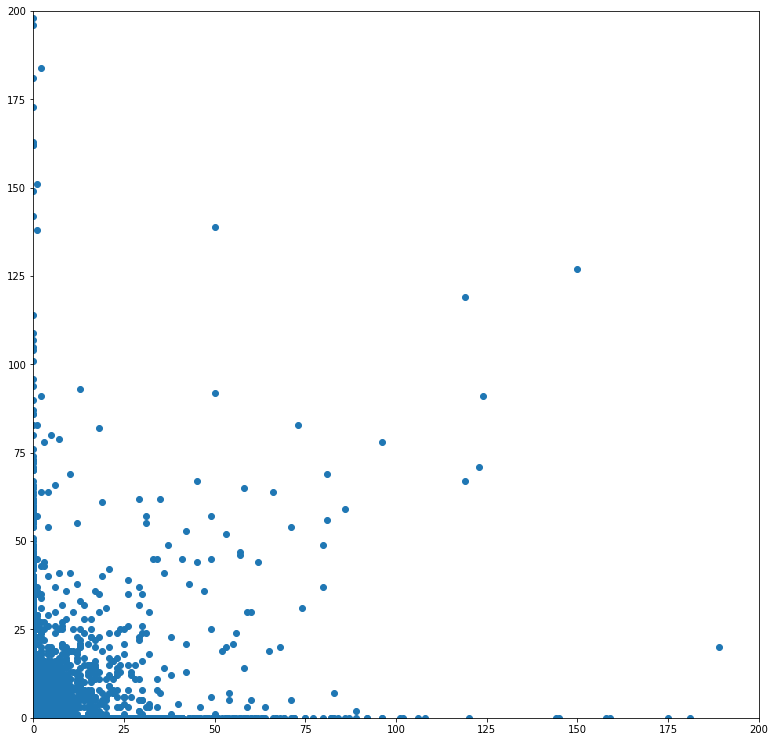

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

xarr = []
yarr = []
for word, xy_pair in word_dict.iteritems():
    xarr.append(xy_pair[0])
    yarr.append(xy_pair[1])
    

plt.figure(figsize = (13,13))
size = 200
plt.axis([0,size,0,size])
plt.scatter(xarr,yarr)
plt.show()

In [12]:
# sort through the dictionary and pull out the words closes to the axis of language we want
import math

def get_top_hits(word_dict, topn=200, xmin=20, cut_angle=20, xmax=60000, ymin=0, ymax=30):
    final_list = []
    for word, xy in word_dict.iteritems():
        if xy[0] <= xmax and xy[0] >= xmin and xy[1] <= ymax and xy[1] >= ymin:
            if float(xy[1])/float(xy[0]+1) < math.tan(math.radians(cut_angle)):
                #print word, xy[0], xy[1], "\t",float(xy[1])/float(xy[0]+1), math.tan(math.radians(cut_angle))
                final_list.append( (word, xy))
    
    final_list.sort(key=lambda x: x[1][0])
    final_list.reverse()
    return final_list[:topn]

def stringify_list(lhits):
    ret_strings = []
    for hit in lhits:
        #ret_strings.append("\"(\\W {}|{} \\W)\"".format(hit[0], hit[0]))
        ret_strings.append("\" {} \"".format(hit[0]))
    return ','.join(ret_strings)
    
        
final_list = get_top_hits(word_dict, 200)
print stringify_list(final_list)
if True:
    for item in final_list:
        print item

" und "," die "," der "," fr "," sie "," mit "," von "," wir "," im "," das "," zu "," den "," auf "," ist "," ber "," mehr "," eine "," bei "," uns "," ein "," sich "," zum "," kontakt "," ihre "," des "," oder "," unsere "," gmbh "," auch "," als "," am "," sind "," in der "," ihr "," dem "," aus "," kommentare "," nach "," zur "," alle "," kunden "," danke "," um "," fr die "," wie "," es "," danke an "," einen "," juni "," einer "," einem "," bis "," nicht "," durch "," wird "," impressum "," werden "," akademie "," hotel "," aegon "," haben "," hat "," neue "," unser "," hier "," sterreich "," angebote "," jetzt "," ich "," finden "," produkte "," nur "," unserer "," ber uns "," erfahren "," ihren "," ihnen "," knnen "," ihrer "," zubehr "," unternehmen "," informationen "," sie sich "," agentur "," finden sie "," vom "," wien "," sowie "," ab "," additiv "," webdesign "," newsletter "," ag "," unseren "," mit dem "," bilder "," weitere "," dieser "," seit "," bei der "," themen "

In [22]:
# Final cell, choose a reference language, and get list of keywords against that for the others.
languages = [
    "spanish",
    "swedish",
    "french",
    "danish",
    "dutch",
    "italian",
    "czech",
    "portugese",
    "german",
    "norwegian",
    "polish",
    "turkish",
    "englishuk",
]
# source of interest should be source_2, which ends up on x axis <->
ref_language = "englishuk"
path_ref_language = "temp/language/language_{}_visible.tsv".format(ref_language)

for language in languages:
    path_language = "temp/language/language_{}_visible.tsv".format(language)
    word_dict = get_dict_word_pairs(path_language, path_ref_language)
    final_list = get_top_hits(word_dict, 200)
    length_list = len(final_list)
    print "    [\n        \"--{} {}--\", {},\n    ],".format(language, length_list, stringify_list(final_list))


    [
        "--spanish 200--", " de "," y "," la "," en "," el "," para "," que "," los "," con "," del "," ms "," las "," de la "," un "," por "," o "," su "," se "," una "," al "," ver "," es "," en el "," datos "," informacin "," tu "," lo "," servicios "," sus "," en la "," de los "," contacto "," nuestros "," ver ms "," a la "," como "," sobre "," nuestra "," sitio "," nuestro "," productos "," personales "," datos personales "," cualquier "," de las "," noticias "," uso "," todos "," tel: "," nosotros "," leer "," gestin "," accesorios "," este "," seguir "," asyse "," desde "," soluciones "," local: "," aviso "," te "," ser "," para el "," leyendo "," correo: "," seguridad "," seguir leyendo "," local: tel: "," servicio "," empresa "," correo "," todos los "," tel: correo: "," clientes "," inicio "," somos "," alejandro "," comprar "," privacidad "," gama "," usuario "," est "," buenos "," si "," nos "," qu "," web: "," derechos "," todo "," esta "," sin "," le "," lnea "," qu

    [
        "--dutch 200--", " de "," en "," van "," het "," een "," op "," voor "," met "," je "," te "," bij "," meer "," dat "," ons "," u "," zijn "," disasters: "," aan "," onze "," van de "," uw "," in de "," om "," die "," door "," wij "," lees "," floods; "," ook "," week "," er "," heeft "," naar "," niet "," natural "," als "," zorg "," technological "," technological disasters: "," natural disasters: "," oostende "," et "," wat "," in het "," uit "," tot "," alle "," dan "," nieuws "," maar "," over ons "," informatie "," dit "," op de "," zonnepanelen "," deze "," geplaatst "," nieuwe "," des "," accessoires "," voor de "," al "," producten "," la "," nog "," werken "," juni "," ik "," accident; "," china "," van het "," op het "," united "," geen "," reizen "," van een "," kan "," lees meer "," hier "," kunnen "," hebben "," met een "," bus "," bekijk "," wordt "," fire "," industry "," united states "," states "," na "," le "," aan de "," les "," veel "," hoe "," is een

    [
        "--german 200--", " und "," die "," der "," fr "," sie "," mit "," von "," wir "," im "," das "," zu "," den "," auf "," ist "," ber "," mehr "," eine "," bei "," uns "," ein "," sich "," zum "," kontakt "," ihre "," des "," oder "," unsere "," gmbh "," auch "," als "," am "," sind "," in der "," ihr "," dem "," aus "," kommentare "," nach "," zur "," alle "," kunden "," danke "," um "," fr die "," wie "," es "," danke an "," einen "," juni "," einer "," einem "," bis "," nicht "," durch "," wird "," impressum "," werden "," akademie "," hotel "," aegon "," haben "," hat "," neue "," unser "," hier "," sterreich "," angebote "," jetzt "," ich "," finden "," produkte "," nur "," unserer "," ber uns "," erfahren "," ihren "," ihnen "," knnen "," ihrer "," zubehr "," unternehmen "," informationen "," sie sich "," agentur "," finden sie "," vom "," wien "," sowie "," ab "," additiv "," webdesign "," newsletter "," ag "," unseren "," mit dem "," bilder "," weitere "," dieser "

    [
        "--englishuk 0--", ,
    ],


In [309]:
# ambientalbr.com.br
!. ../set_flag/return_full_text_on; echo elglobo.com.mx | python ../bin/urlChecker.py | python ../classifier/classify.py > temp_file.tsv
with open("temp_file.tsv",'r') as source:
    for line in source:
        cols = line.split('\t')
        for col in cols:
            print col

----------
elglobo.com.mx
#% starting script

processing input

elglobo.com.mx
http://www.elglobo.com.mx/
Foreign
25586
348
0
keywords marketing: []
0
keywords staffing: []
2
desc marketing: [u'a hr', u'post']
1
desc staffing: [u'seo']
0
--marketing-- []
1
--staffing-- [u'post']
0
 --medical--  []
0
--goverment-- []
0
--education-- []
0
--retail-- []
0
--food-- []
0
--emergency services-- []
0
--banking-- []
0
--manufacturing-- []
0
--telecommunications-- []
0
--hotels-restaurants-- []
0
--tourist-attractions-- []
0
--organizations-- []
0
--animal-rescue-shelter-- []
0
--military-- []
29
--spanish 200-- [u' la ', u' en ', u' el ', u' para ', u' que ', u' los ', u' con ', u' del ', u' por ', u' o ', u' tu ', u' lo ', u' nuestros ', u' nuestra ', u' nuestro ', u' todos ', u' aviso ', u' te ', u' todos los ', u' inicio ', u' derechos ', u' todo ', u' mejor ', u' aviso de ', u' nuestras ', u' nombre ', u' mi ', u' producto ', u' eventos ']
1
--swedish 200-- [u' en ']
3
--french 200-- [u' l